# Explore mcmc results and create dataframes of parameters and ccn results.

In [1]:

from models import CCNmodel_m2
from config import get_Extra, load_data
import pints
import pints.io
import pints.plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import matplotlib.gridspec as gridspec
from scipy.stats import skew
from scipy.stats import mode
import seaborn as sns

In [2]:
# make trace plots:
def trace_plot(plt_samples, burn_in, initial_guess, param_name):
    f,axs = pints.plot.trace(plt_samples[:, :, :], parameter_names=[param_name])
    f.set_figheight(5)
    axs[0][0].axvline(x=plt_samples[:, burn_in:, :].mean(), color='r', linestyle='--', label='mcmc mean '+str(np.round(plt_samples[:, burn_in:, :].mean(),3)))
    axs[0][0].axvline(x=np.median(plt_samples[:, burn_in:, :]), color='r', label='mcmc median '+str(np.round(np.median(plt_samples[:, burn_in:, :]),3)))
    axs[0][0].axvline(x=mode(plt_samples[:, burn_in:, :],axis=None)[0], linestyle=':', color='r', label='mcmc mode '+str(np.round(mode(plt_samples[:, burn_in:, :],axis=None)[0],3)))
    axs[0][0].axvline(x=initial_guess, color='b', linestyle='--', label='initial guess')
    axs[0][0].legend()
    axs[0][1].axvline(x=burn_in, color='grey', linestyle='--')

In [3]:
nedmead_results = pd.read_csv('../results/result_nedler_mead_org0p12.csv')

## Example analysis of one time-step (trace plots and marginal pdfs):

In [4]:
# window idx for example:
idx = 20

#set number of discarded iterations:
burn_in = 20000

#get chains for that window:
chains = sorted(glob.glob('../chains/m2_30k_5chains/mcmc_30k_m2_5chains_'+str(idx)+'_*.csv'))
chains

['../chains/m2_30k_5chains/mcmc_30k_m2_5chains_20_0.csv',
 '../chains/m2_30k_5chains/mcmc_30k_m2_5chains_20_1.csv',
 '../chains/m2_30k_5chains/mcmc_30k_m2_5chains_20_2.csv',
 '../chains/m2_30k_5chains/mcmc_30k_m2_5chains_20_3.csv',
 '../chains/m2_30k_5chains/mcmc_30k_m2_5chains_20_4.csv']

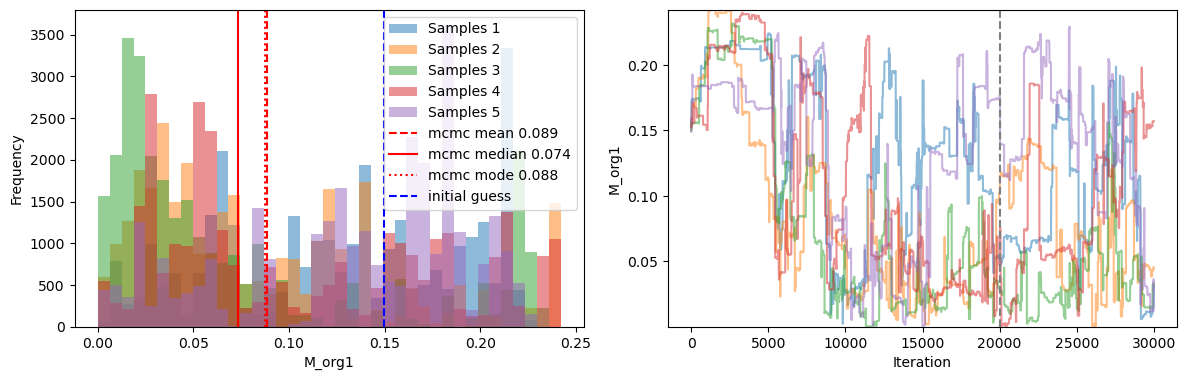

In [92]:
# load data:
M_org1_chains = pints.io.load_samples(chains[0])
D1_chains = pints.io.load_samples(chains[1])
N1_chains = pints.io.load_samples(chains[2])
D2_chains = pints.io.load_samples(chains[3])
N2_chains = pints.io.load_samples(chains[4])

#get initial guesses for parameters:
bimodal_params = pd.read_csv('../input_data/bimodal_params_windows.csv')
M_org1_initial = pd.read_csv('../input_data/M_org1_initialguess.csv')

trace_plot(np.expand_dims(M_org1_chains, axis=2), burn_in, M_org1_initial['M_org1'][20], 'M_org1')

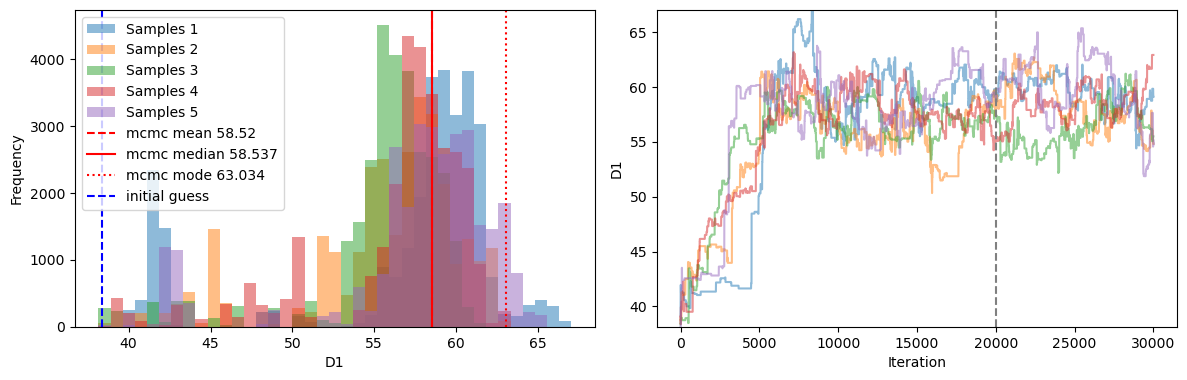

In [93]:
trace_plot(np.expand_dims(D1_chains, axis=2), burn_in, bimodal_params['mode1_d'][20], 'D1')

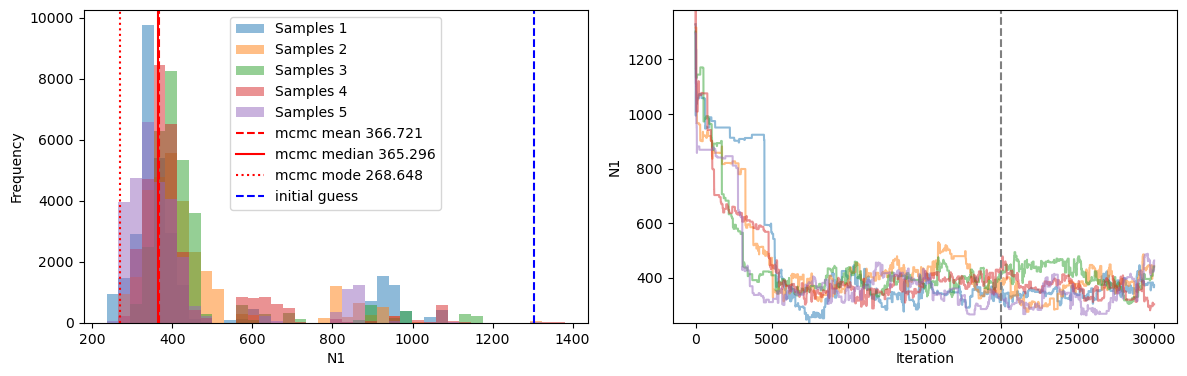

In [94]:
trace_plot(np.expand_dims(N1_chains, axis=2), burn_in, bimodal_params['NSD1_sum'][20], 'N1')

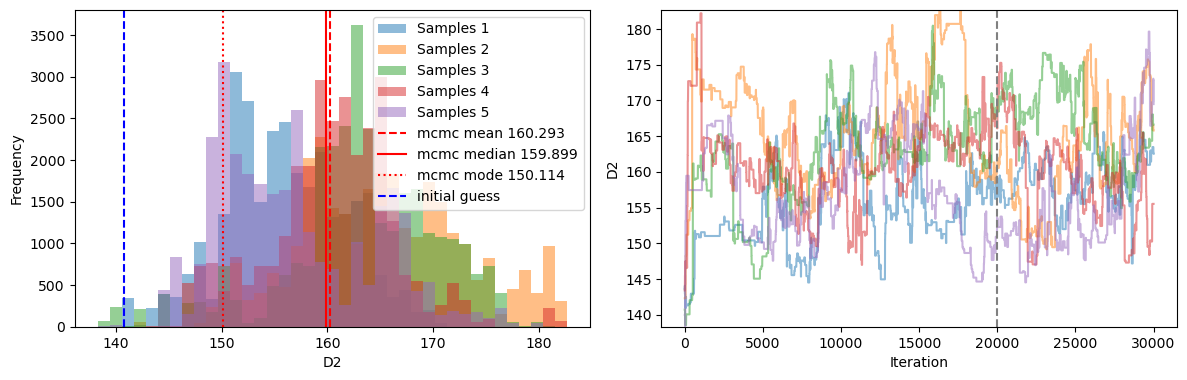

In [95]:
trace_plot(np.expand_dims(D2_chains, axis=2), burn_in, bimodal_params['mode2_d'][20], 'D2')

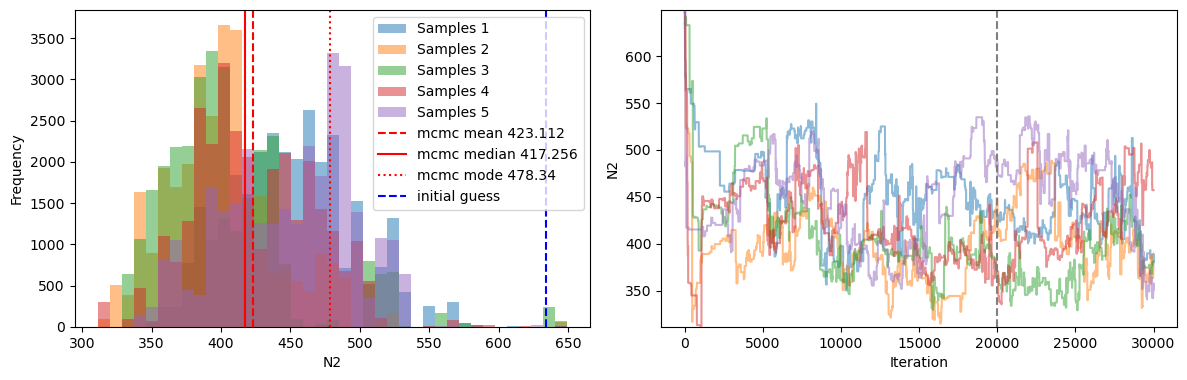

In [96]:
trace_plot(np.expand_dims(N2_chains, axis=2), burn_in, bimodal_params['NSD2_sum'][20], 'N2')

In [97]:
# print rhat statistics:
cut_off = 0.6
print('M_org1 rhat:', pints.rhat(M_org1_chains, cut_off), 
      'D1 rhat:', pints.rhat(D1_chains, cut_off),
      'N1 rhat:', pints.rhat(N1_chains, cut_off),
      'D2 rhat:', pints.rhat(D2_chains, cut_off),
      'N2 rhat:', pints.rhat(N2_chains, cut_off))

# print ess statistics:
#samples = np.column_stack([M_org1_chains[:,burn_in:].reshape(-1), D1_chains[:,burn_in:].reshape(-1), N1_chains[:,burn_in:].reshape(-1), D2_chains[:,burn_in:].reshape(-1), N2_chains[:,burn_in:].reshape(-1)])
#print('total ess:', pints.effective_sample_size(samples))

M_org1 rhat: 1.46665733438637 D1 rhat: 1.3612869425576168 N1 rhat: 1.3702711562118814 D2 rhat: 1.4752663497043832 N2 rhat: 1.5754598841050587


(<Figure size 1500x1500 with 25 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='D1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='N1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='D2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel='M_org1', ylabel='N2'>, <Axes: xlabel='D1'>,
         <Axes: xlabel='N1'>, <Axes: xlabel='D2'>, <Axes: xlabel='N2'>]],
       dtype=object))

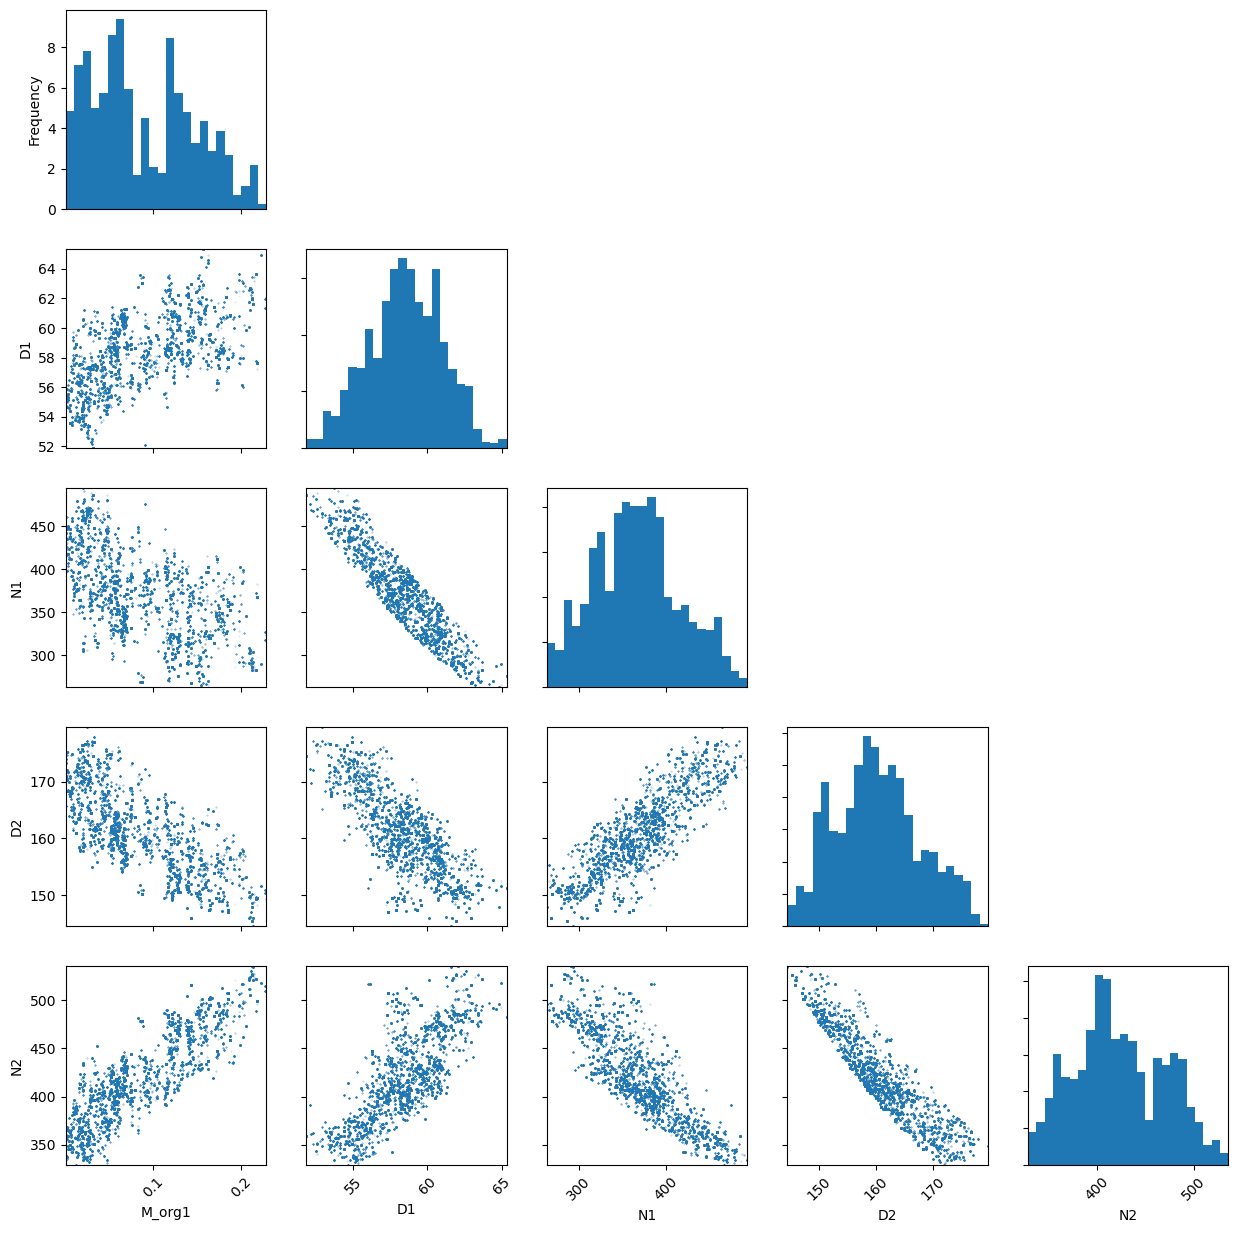

In [98]:
samples = np.stack([M_org1_chains[:,burn_in:], D1_chains[:,burn_in:], N1_chains[:,burn_in:], D2_chains[:,burn_in:], N2_chains[:,burn_in:]], axis=2)
pints.plot.pairwise(np.vstack(samples), kde=False, parameter_names=['M_org1', 'D1', 'N1', 'D2', 'N2'])

/tmp/ipykernel_2782969/1969659899.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nedmead_ccn = np.fromstring(nedmead_results['Predicted_CCN'][idx])


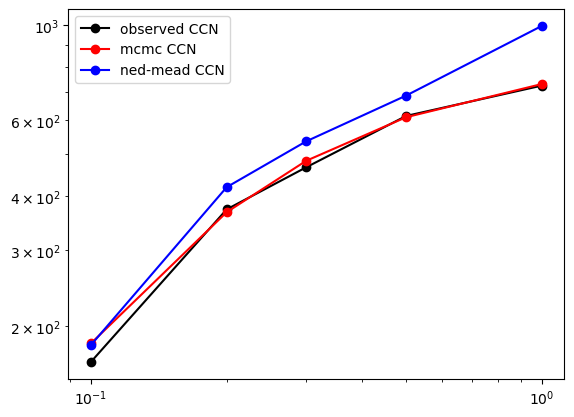

In [99]:
# compare CCN spectra:

# setup model:
Extra = get_Extra(idx)
model_data, initial_guesses, prior_params, response = load_data(idx)
m = CCNmodel_m2(Extra, model_data, return_all=True)

test_model_output = m(np.mean(samples, axis=(0,1)))

ss = [0.1,0.2,0.3,0.5,1.0]

nedmead_ccn = np.fromstring(nedmead_results['Predicted_CCN'][idx]) 

plt.loglog(ss, response, label='observed CCN', color='k', marker='o')
plt.loglog(ss, test_model_output[0]+test_model_output[1], label='mcmc CCN', color='r', marker='o')
plt.loglog(ss, nedmead_ccn, label='ned-mead CCN', color='b', marker='o')
plt.legend()

## Main data processing (create parameter dataframe and CCN results dataframe):

To get parameter values and statistics, run summarize_mcmc_posteriors.py

In [5]:
# load mcmc parameters for summary statistics and calculate CCN results:
mcmc_params = pd.read_csv('../results/summary_30k_m2_5chains.csv')

In [6]:
# calculate mcmc results (or load farther down)
mcmc_results = pd.DataFrame({'datetime': mcmc_params['datetime']})

cols_to_add = [
    'NRMSE', 'predicted_CCN1', 'predicted_CCN2', 'inorg_density', 'Predicted_CCN',
    'f_org1', 'f_AS1', 'f_BC1', 'f_org2', 'f_AS2', 'f_BC2',
    'k1', 'k2', 'mass_aitken', 'mass_accumulation'
]

for col in cols_to_add:
    if col in ['predicted_CCN1', 'predicted_CCN2', 'Predicted_CCN']:
        mcmc_results[col] = pd.Series([np.nan]*5, dtype='object')
    else:
        mcmc_results[col] = np.nan

check_rows = []

for ii in range(len(mcmc_params)):

    # skip rows with NaN:
    if pd.isna(mcmc_params.iloc[ii]).any():
        all_cols_to_nan = mcmc_results.columns.difference(['datetime'])
        mcmc_results.loc[ii, all_cols_to_nan] = np.nan

    else:
        try:
            Extra = get_Extra(ii)
            model_data, initial_guesses, prior_params, response = load_data(ii)
            m = CCNmodel_m2(Extra, model_data, return_all=True)

            model_parameters = [mcmc_params.iloc[ii]['M_org1_median'], mcmc_params.iloc[ii]['D1_median'], mcmc_params.iloc[ii]['N1_median'], mcmc_params.iloc[ii]['D2_median'], mcmc_params.iloc[ii]['N2_median']]
            ccn1, ccn2, k1, k2, k_inorg1, k_inorg2, mass_frac_aitken, mass_frac_accumulation, total_ait_mass, total_acc_mass, total_mass,info_mass, NSD1_vec, NSD2_vec = m(model_parameters)

            nrmse = np.sqrt(np.mean((response - (ccn1+ccn2))**2)) / np.mean(response)

            mcmc_results.at[ii, 'NRMSE'] = nrmse
            mcmc_results.at[ii, 'predicted_CCN1'] = ccn1
            mcmc_results.at[ii, 'predicted_CCN2'] = ccn2
            mcmc_results.at[ii, 'inorg_density'] = Extra['rho_inorg']
            mcmc_results.at[ii, 'Predicted_CCN'] = ccn1 + ccn2
            mcmc_results.at[ii, 'f_org1'] = mass_frac_aitken[0]
            mcmc_results.at[ii, 'f_AS1'] = mass_frac_aitken[2]
            mcmc_results.at[ii, 'f_BC1'] = mass_frac_aitken[4]
            mcmc_results.at[ii, 'f_org2'] = mass_frac_accumulation[0]
            mcmc_results.at[ii, 'f_AS2'] = mass_frac_accumulation[2]
            mcmc_results.at[ii, 'f_BC2'] = mass_frac_accumulation[4]
            mcmc_results.at[ii, 'k1'] = k1
            mcmc_results.at[ii, 'k2'] = k2
            mcmc_results.at[ii, 'mass_aitken'] = total_ait_mass
            mcmc_results.at[ii, 'mass_accumulation'] = total_acc_mass

        except Exception as e:
            print(f"No model output for median parameters for row {ii}: {e}")
            mcmc_results.loc[ii, all_cols_to_nan] = np.nan
            check_rows.append(ii)
            continue



No model output for median parameters for row 115: cannot unpack non-iterable NoneType object
No model output for median parameters for row 147: cannot unpack non-iterable NoneType object
No model output for median parameters for row 150: cannot unpack non-iterable NoneType object
No model output for median parameters for row 172: cannot unpack non-iterable NoneType object
No model output for median parameters for row 195: cannot unpack non-iterable NoneType object
No model output for median parameters for row 206: cannot unpack non-iterable NoneType object
No model output for median parameters for row 231: cannot unpack non-iterable NoneType object
No model output for median parameters for row 244: cannot unpack non-iterable NoneType object
No model output for median parameters for row 286: cannot unpack non-iterable NoneType object
No model output for median parameters for row 315: cannot unpack non-iterable NoneType object
No model output for median parameters for row 368: cannot un

In [7]:
mcmc_results.to_csv('../results/30k_m2_logparams_ccn_results.csv')

In [108]:
mcmc_results = pd.read_csv('../results/30k_m2_5chains_ccn_results.csv')

In [9]:
# how many time-steps show convergence:
rhat_thresh = 1.5
num_conv = mcmc_params.where(mcmc_params['M_org1_rhat'] < rhat_thresh).where(mcmc_params['D1_rhat'] < rhat_thresh).where(mcmc_params['N1_rhat'] < rhat_thresh).where(mcmc_params['D2_rhat'] < rhat_thresh).where(mcmc_params['N2_rhat'] < rhat_thresh).dropna()

print(f"Number of total time-steps showing convergence (rhat < {rhat_thresh}): {num_conv.shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing M_org1 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['M_org1_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing D1 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['D1_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing N1 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['N1_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing D2 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['D2_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing N2 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['N2_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")

Number of total time-steps showing convergence (rhat < 1.5): 1855 out of 4751
Number of time-steps showing M_org1 convergence (rhat < 1.5): 2942 out of 4751
Number of time-steps showing D1 convergence (rhat < 1.5): 2314 out of 4751
Number of time-steps showing N1 convergence (rhat < 1.5): 2258 out of 4751
Number of time-steps showing D2 convergence (rhat < 1.5): 2646 out of 4751
Number of time-steps showing N2 convergence (rhat < 1.5): 2546 out of 4751


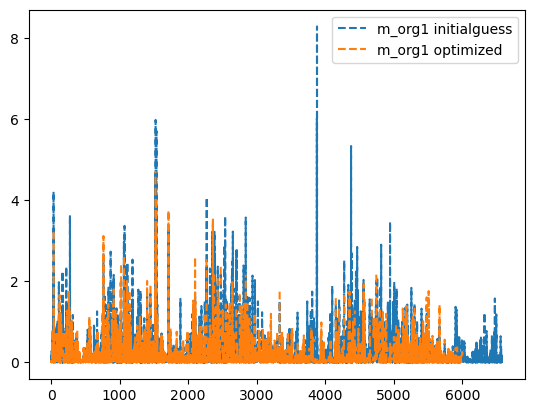

In [10]:
m_org1_guess = pd.read_csv('../input_data/M_org1_initialguess.csv')

plt.plot(m_org1_guess, label='m_org1 initialguess', linestyle='--')
plt.plot(mcmc_params['M_org1_mean'], label='m_org1 optimized', linestyle='--')
plt.legend()

In [11]:
# add seaon to mcmc_results:
def get_season(date):
    if date.month in [3, 4, 5]:
        return 0
    elif date.month in [6, 7, 8]:
        return 1
    elif date.month in [9, 10, 11]:
        return 2
    else:
        return 3
    

observed_results = pd.read_csv('../input_data/CCN.csv')
sc_cols = ['SC1', 'SC2', 'SC3', 'SC4', 'SC5']
observed_results['CCN'] = observed_results[sc_cols].values.tolist()

if nedmead_results['Predicted_CCN'].map(type).eq(str).any():
    nedmead_results['Predicted_CCN'] = nedmead_results['Predicted_CCN'].apply(
        lambda x: np.fromstring(x.strip('[]'), sep=' ') 
    )
if mcmc_results['Predicted_CCN'].map(type).eq(str).any():
    mcmc_results['Predicted_CCN'] = mcmc_results['Predicted_CCN'].apply(
        lambda x: np.fromstring(x.strip('[]'), sep=' ') if isinstance(x, str) else x
    )

# Helper to compute seasonal stats
def compute_seasonal_stats(df, column_name, label):
    seasonal_stats = []

    for season, group in df.groupby('season'):
        valid_rows = group[column_name].dropna()
        arrays = [np.array(row) for row in valid_rows if isinstance(row, (list, np.ndarray))]

        if arrays:
            stacked = np.vstack(arrays)
            seasonal_stats.append({
                'season': season,
                'source': label,
                'median': np.median(stacked, axis=0),
                'p25': np.percentile(stacked, 25, axis=0),
                'p75': np.percentile(stacked, 75, axis=0)
            })
        else:
            seasonal_stats.append({
                'season': season,
                'source': label,
                'median': np.nan,
                'p25': np.nan,
                'p75': np.nan
            })

    return pd.DataFrame(seasonal_stats)

# Apply to all three datasets
mcmc_results['season'] = pd.to_datetime(mcmc_results['datetime']).apply(get_season)
nedmead_results['season'] = pd.to_datetime(nedmead_results['datetime']).apply(get_season)
observed_results['season'] = pd.to_datetime(observed_results['datetime']).apply(get_season)

seasonal_stats_mcmc = compute_seasonal_stats(mcmc_results, 'Predicted_CCN', 'mcmc')
seasonal_stats_nedmead = compute_seasonal_stats(nedmead_results, 'Predicted_CCN', 'nedmead')
seasonal_stats_obs = compute_seasonal_stats(observed_results, 'CCN', 'observed')

seasonal_stats_mcmc_rhatmorg = compute_seasonal_stats(mcmc_results.where(mcmc_params['M_org1_rhat']<1.2), 'Predicted_CCN', 'mcmc')

# Combine all into one DataFrame
seasonal_stats_all = pd.concat([seasonal_stats_mcmc_rhatmorg, seasonal_stats_nedmead, seasonal_stats_obs], ignore_index=True)


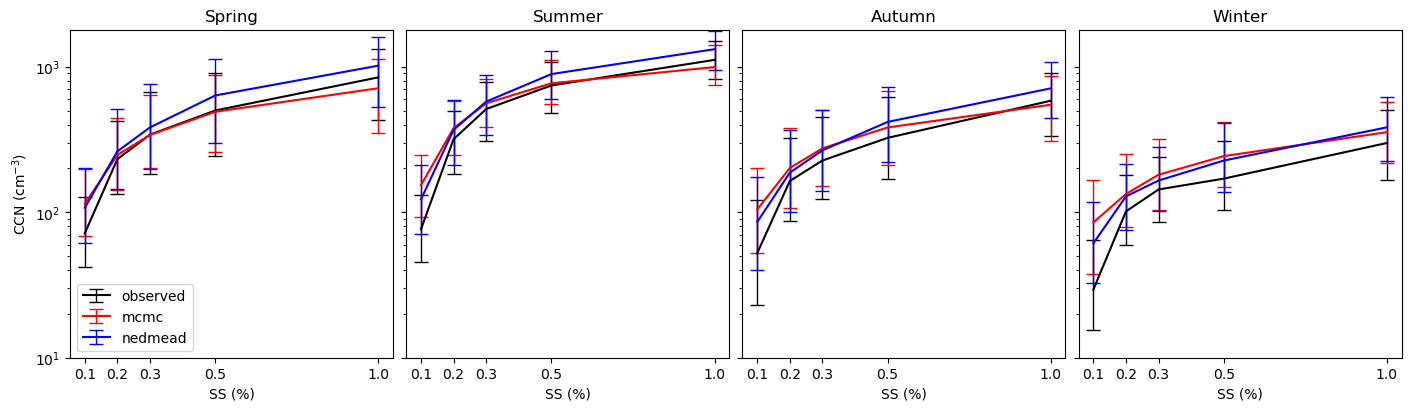

In [12]:
# plot CCN for each season:

fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)
ss = [0.1,0.2,0.3,0.5,1.0]

for i in range(4):
    for j, source in enumerate(['observed', 'mcmc', 'nedmead']):
        seasonal_data = seasonal_stats_all.loc[
            (seasonal_stats_all['season'] == i) & (seasonal_stats_all['source'] == source)
        ]
        
        if not seasonal_data.empty:
            median = seasonal_data['median'].iloc[0]
            p25 = seasonal_data['p25'].iloc[0]
            p75 = seasonal_data['p75'].iloc[0]

            # Calculate asymmetric error bars
            yerr_lower = median - p25
            yerr_upper = p75 - median
            yerr = np.vstack([yerr_lower, yerr_upper])  # shape (2, N)

            axes[i].errorbar(ss, median, yerr=yerr, label=source, color=['k', 'r', 'b'][j], capsize=5, elinewidth=1, markeredgewidth=1)
            #axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].set_title(['Spring', 'Summer', 'Autumn', 'Winter'][i])
            axes[i].set_ylim(1e1, 1.8e3)
            axes[i].set_xlabel('SS (%)')
            axes[i].set_xticks(ss)
        if i == 0:
            axes[i].set_ylabel('CCN (cm$^{-3}$)')
            axes[i].legend()


Text(0, 0.5, 'Counts')

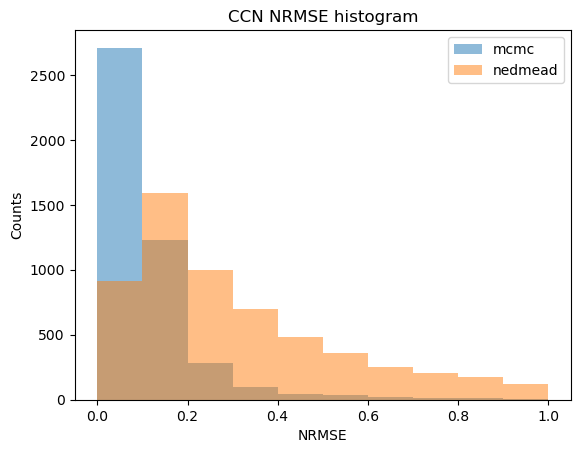

In [13]:
# histogram of different NRMSEs:
bins = np.linspace(0, 1, 11) 
plt.hist(mcmc_results['NRMSE'], bins=bins, alpha=0.5, label='mcmc')
plt.hist(nedmead_results['NRMSE'], bins=bins, alpha=0.5, label='nedmead')
plt.legend()
plt.title('CCN NRMSE histogram')
plt.xlabel('NRMSE')
plt.ylabel('Counts')

Text(0, 0.5, 'Probability Density')

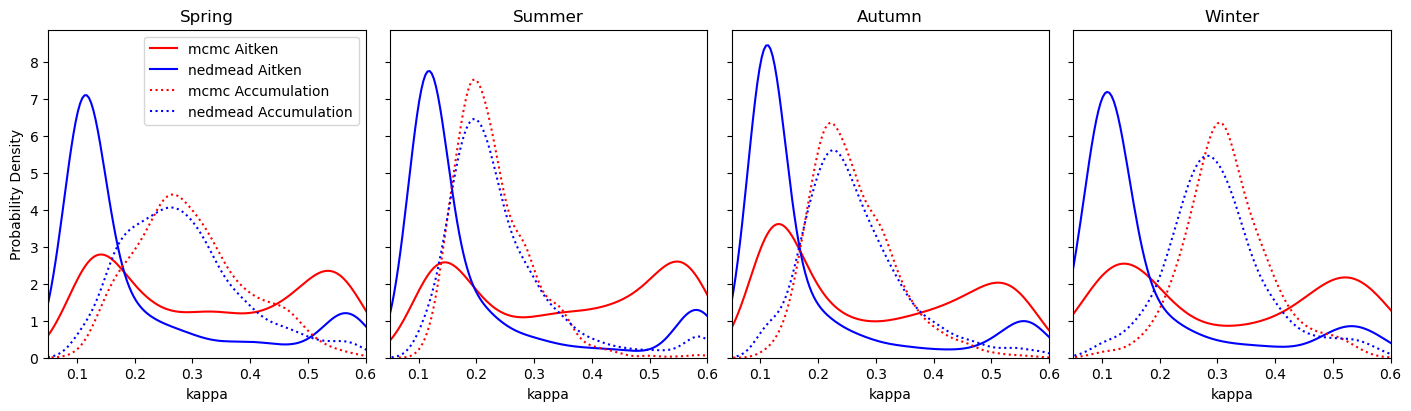

In [25]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    group_mcmc = mcmc_results.where(mcmc_params['M_org1_rhat']<1.5)[mcmc_results['season'] == season]
    group_nedmead = nedmead_results[nedmead_results['season'] == season]
    sns.kdeplot(group_mcmc['k1'].dropna(), ax=ax, label='mcmc Aitken', color='r', linewidth=1.5)
    sns.kdeplot(group_nedmead['k1'].dropna(), ax=ax, label='nedmead Aitken', color='b', linewidth=1.5)
    sns.kdeplot(group_mcmc['k2'].dropna(), ax=ax, label='mcmc Accumulation', color='r', linestyle=':', linewidth=1.5)
    sns.kdeplot(group_nedmead['k2'].dropna(), ax=ax, label='nedmead Accumulation', color='b', linestyle=':', linewidth=1.5)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlim(0.05, 0.6)
    ax.set_xlabel('kappa')

axes[0].legend()
axes[0].set_ylabel('Probability Density')



/tmp/ipykernel_2498674/1254240619.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])
/tmp/ipykernel_2498674/1254240619.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])


[Text(0, 0, 'Spring'),
 Text(1, 0, 'Summer'),
 Text(2, 0, 'Autumn'),
 Text(3, 0, 'Winter')]

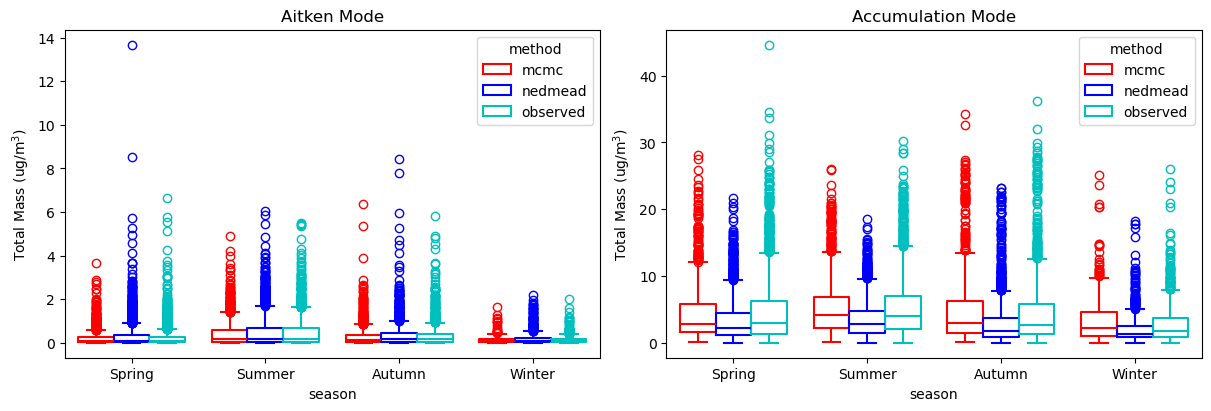

In [16]:
calc_mass = pd.read_csv('/proj/bolinc/users/x_maude/CCN_closure/Modal-Aerosol-Composition/input_data/total_mass_median_NSDparams.csv')

mass_df = pd.DataFrame({
    'datetime': mcmc_results['datetime'],
    'mass_aitken': mcmc_results['mass_aitken'],
    'mass_accumulation': mcmc_results['mass_accumulation'],
    'season': mcmc_results['season'],
    'method': 'mcmc'
})
mass_df_nedmead = pd.DataFrame({
    'datetime': nedmead_results['datetime'],
    'mass_aitken': nedmead_results['mass_aitken'],
    'mass_accumulation': nedmead_results['mass_accumulation'],
    'season': nedmead_results['season'],
    'method': 'nedmead'
})
mass_df_obs = pd.DataFrame({
    'datetime': calc_mass['datetime'],
    'mass_aitken': calc_mass['aitken_mass'],
    'mass_accumulation': calc_mass['accum_mass'],
    'season': mcmc_results['season'],
    'method': 'observed'
})
mass_df = pd.concat([mass_df, mass_df_nedmead, mass_df_obs], ignore_index=True)

fig,axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4), constrained_layout=True)

sns.boxplot(x='season', y='mass_aitken', hue='method', data=mass_df, palette=['r','b','c'], fill=False, ax=axes[0])
sns.boxplot(x='season', y='mass_accumulation', hue='method', data=mass_df, palette=['r','b','c'], fill=False, ax=axes[1])
axes[0].set_title('Aitken Mode')
axes[1].set_title('Accumulation Mode')
axes[0].set_ylabel('Total Mass (ug/m$^3$)')
axes[1].set_ylabel('Total Mass (ug/m$^3$)')
axes[0].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])
axes[1].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])

Text(0, 0.5, 'Count')

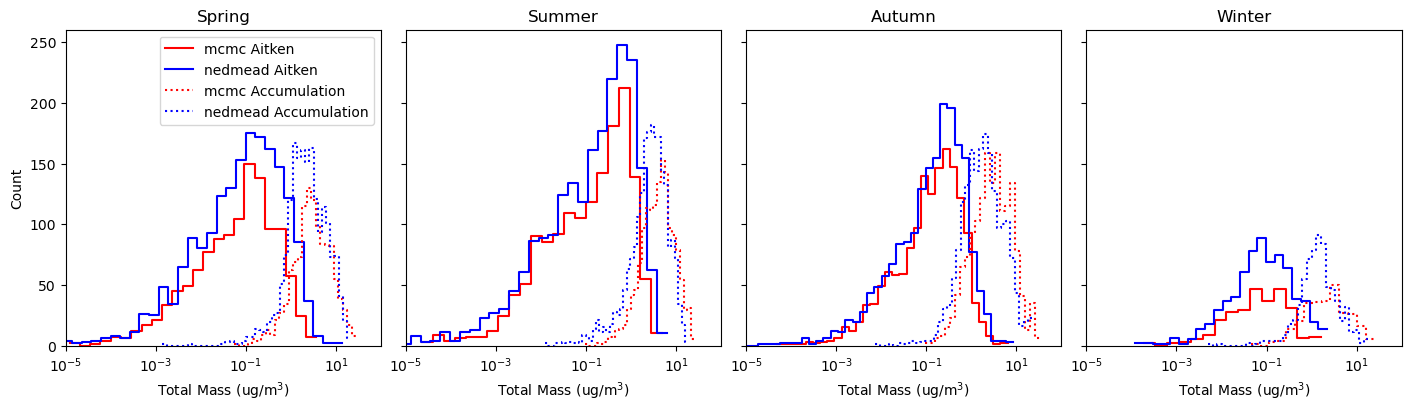

In [17]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    group_mcmc = mcmc_results[mcmc_results['season'] == season]
    group_nedmead = nedmead_results[nedmead_results['season'] == season]
    sns.histplot(group_mcmc['mass_aitken'].dropna(), ax=ax, label='mcmc Aitken', color='r', linewidth=1.5,log_scale=True, element="step", fill=False)
    sns.histplot(group_nedmead['mass_aitken'].dropna(), ax=ax, label='nedmead Aitken', color='b', linewidth=1.5, log_scale=True, element="step", fill=False)
    sns.histplot(group_mcmc['mass_accumulation'].dropna(), ax=ax, label='mcmc Accumulation', color='r', linestyle=':', linewidth=1.5, log_scale=True, element="step", fill=False)
    sns.histplot(group_nedmead['mass_accumulation'].dropna(), ax=ax, label='nedmead Accumulation', color='b', linestyle=':', linewidth=1.5, log_scale=True, element="step", fill=False)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlabel('Total Mass (ug/m$^3$)')
    ax.set_xlim(1e-5, 1e2)

 
axes[0].legend()
axes[0].set_ylabel('Count')

Text(0, 0.5, 'Density')

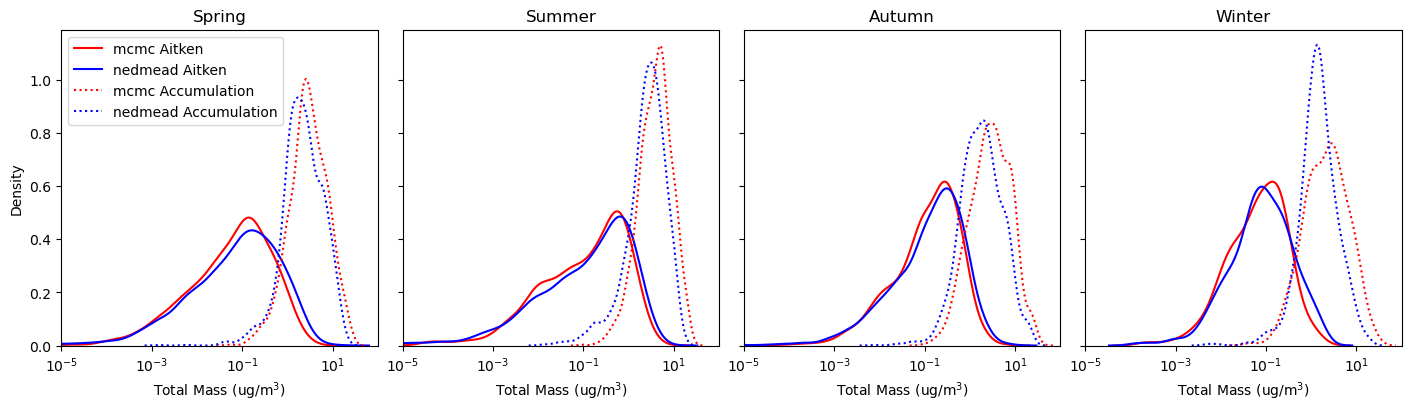

In [18]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    group_mcmc = mcmc_results[mcmc_results['season'] == season]
    group_nedmead = nedmead_results[nedmead_results['season'] == season]
    sns.kdeplot(group_mcmc['mass_aitken'].dropna(), ax=ax, label='mcmc Aitken', color='r', linewidth=1.5,log_scale=True)
    sns.kdeplot(group_nedmead['mass_aitken'].dropna(), ax=ax, label='nedmead Aitken', color='b', linewidth=1.5, log_scale=True)
    sns.kdeplot(group_mcmc['mass_accumulation'].dropna(), ax=ax, label='mcmc Accumulation', color='r', linestyle=':', linewidth=1.5, log_scale=True)
    sns.kdeplot(group_nedmead['mass_accumulation'].dropna(), ax=ax, label='nedmead Accumulation', color='b', linestyle=':', linewidth=1.5, log_scale=True)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlabel('Total Mass (ug/m$^3$)')
    ax.set_xlim(1e-5, 1e2)

 
axes[0].legend()
axes[0].set_ylabel('Density')

Text(0, 0.5, 'Count')

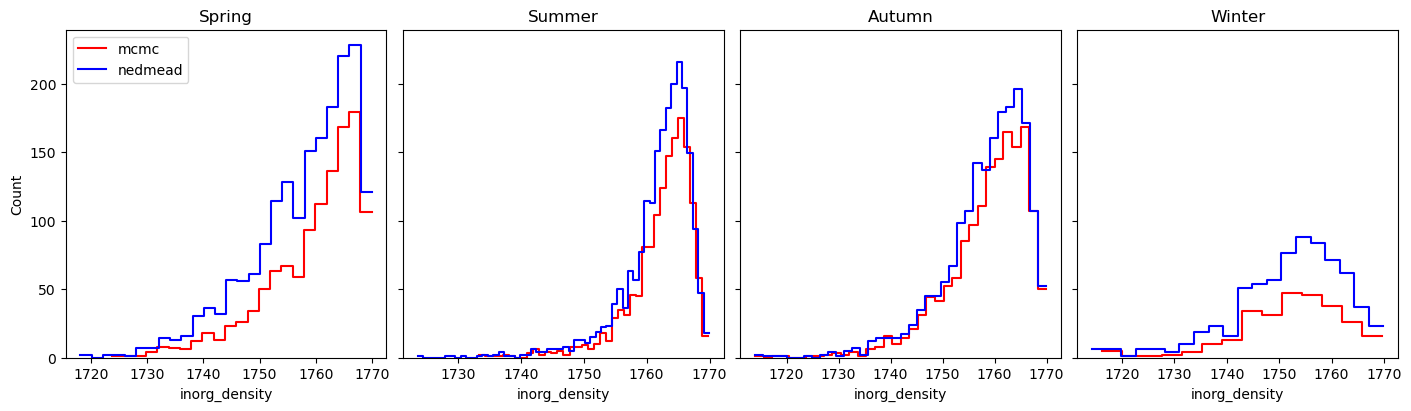

In [19]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    group_mcmc = mcmc_results[mcmc_results['season'] == season]
    group_nedmead = nedmead_results[nedmead_results['season'] == season]
    sns.histplot(group_mcmc['inorg_density'].dropna(), ax=ax, label='mcmc', color='r', linewidth=1.5, element="step", fill=False)
    sns.histplot(group_nedmead['inorg_density'].dropna(), ax=ax, label='nedmead', color='b', linewidth=1.5, element="step", fill=False)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlabel('inorg_density')

 
axes[0].legend()
axes[0].set_ylabel('Count')

Text(0, 0.5, 'Density')

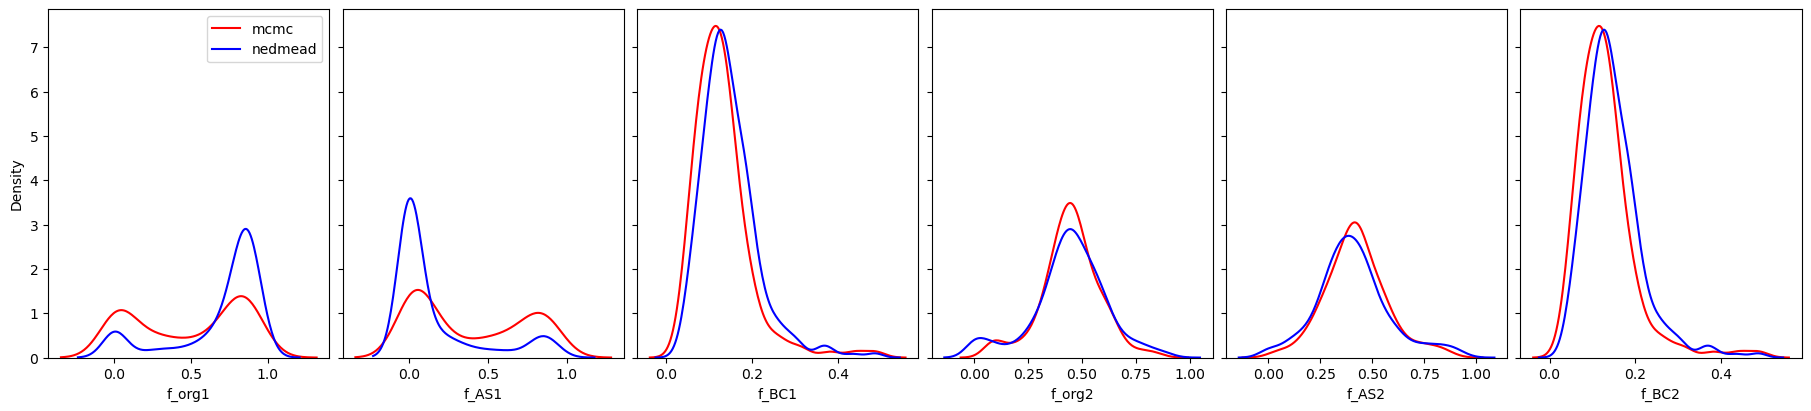

In [20]:
fig,axes = plt.subplots(ncols=6, nrows=1, figsize=(18,4), sharey=True, constrained_layout=True)
fractions = ['f_org1', 'f_AS1', 'f_BC1', 'f_org2', 'f_AS2', 'f_BC2']

for f in range(6):
    ax = axes[f]
    fraction = fractions[f]
    sns.kdeplot(group_mcmc[fraction].dropna(), ax=ax, label='mcmc', color='r', linewidth=1.5)
    sns.kdeplot(group_nedmead[fraction].dropna(), ax=ax, label='nedmead', color='b', linewidth=1.5)

axes[0].legend()
axes[0].set_ylabel('Density')

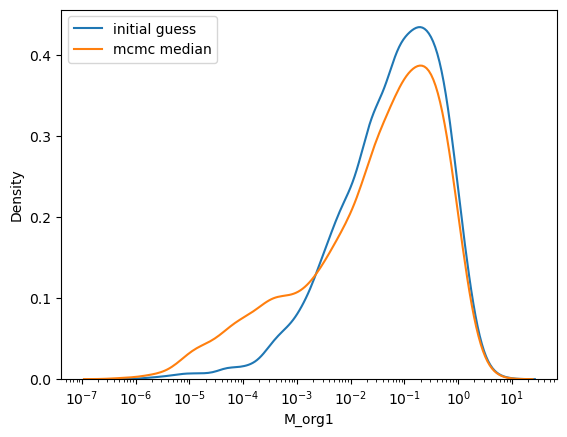

In [22]:
M_org1_initial = pd.read_csv('../input_data/M_org1_initialguess.csv')

sns.kdeplot(M_org1_initial['M_org1'], label='initial guess', log_scale=True)
sns.kdeplot(mcmc_params['M_org1_median'], label='mcmc median', log_scale=True)
plt.legend()

(1e-06, 15.0)

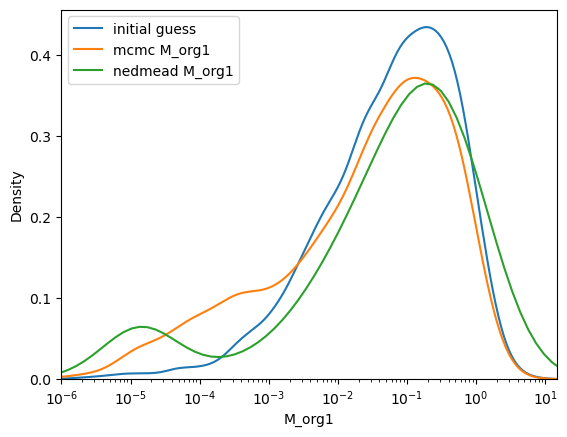

In [23]:
sns.kdeplot(M_org1_initial['M_org1'], label='initial guess', log_scale=True)
sns.kdeplot((mcmc_results['mass_aitken']*mcmc_results['f_org1']), label='mcmc M_org1', log_scale=True)
sns.kdeplot((nedmead_results['mass_aitken']*nedmead_results['f_org1']).where((nedmead_results['mass_aitken']*nedmead_results['f_org1'])>0), label='nedmead M_org1', log_scale=True)
plt.legend()
plt.gca().set_xlim(1e-6, 1.5e1)